# Lower API


- Thiết kế layer trong Keras
    - Kiểm soát các công thức toán học, những tham số của layer

## Import thư viện và đọc data

In [0]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt

## import thư viện backend, hỗ trợ nhũng hàm của keras
from keras import backend as K

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


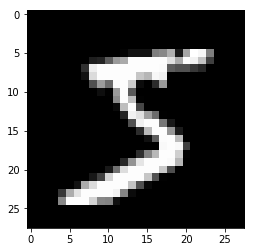

In [0]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

## Custom Layer Keras


Để tùy chỉnh một layer của Keras cách tốt nhất là viết một lớp con của lớp keras.Layers.Layer trong đó cần override những hàm:
- \_\_init__: khởi tạo, lưu tham số cho layer
- build: thiết lập layer dựa vào shape của input, khai báo các biến, các layer ở hàm này
- call: cài đặt những tính toán feedforward


## Bài tập
1. Hãy xây dựng custom layer 

```python
class DoubleFullyConnectedLayer(keras.layers.Layer):
    
    def __init__(self, n_units_1, n_units_2, activation):
```

gồm:
    - 2 lớp Dense chồng nhau: lớp đầu có số neuron là n_units_1, lớp còn lại có số neuron là n_units_2
    - Tự khai báo các biến và thiết lập các phép toán như lớp FullyConnectedLayer ở trên
2. Với lớp được định nghĩa, vãy xây dựng và huấn luyện một model có cấu trúc như sau:
    - Đoán xem trong lớp DoubleFullyConnectedLayer tham số n_units_1 và n_units_2 bằng bao nhiêu?
    
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv_maxpool_block_1 (ConvMa (None, 14, 14, 20)        520       
_________________________________________________________________
conv_maxpool_block_2 (ConvMa (None, 7, 7, 20)          10020     
_________________________________________________________________
flatten_1 (Flatten)          (None, 980)               0         
_________________________________________________________________
double_fully_connected_layer (None, 10)                99110     
=================================================================
Total params: 109,650
Trainable params: 109,650
Non-trainable params: 0
_________________________________________________________________
```


In [0]:
class DoubleFullyConnectedLayer(keras.layers.Layer):
    def __init__(self, n_units_1 = 10, n_units_2 = 10, activation=tf.nn.sigmoid):
        
        # gọi hàm khởi tạo của lớp cha
        super(DoubleFullyConnectedLayer, self).__init__()
       
        # lưu lại số nơ-ron của lớp này
        self.n_units_1 = n_units_1
        self.activation_function = activation
        self.n_units_2 = n_units_2
        self.activation_function = activation

    def build(self, input_shape):
        #  print("build called")
        ## input_shape: là shape của input của layer này
        ## tham số này là bắt buộc
        
        ### Tạo biến có kích thước [input_shape[-1], self.n_units],
        ### các giá trị biến tạo ngẫu nhiên theo phân phối chuẩn mean = 0, std = 0.01
        
        self.kernel1 = self.add_variable(name='kernel1',
                                        shape=[int(input_shape[-1]), self.n_units_1],
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        
        ## Tương tự, khai báo một vector bias
        self.bias1 = self.add_variable(name='bias1',
                                      shape=[self.n_units_1],
                                      initializer=keras.initializers.Ones())
        
        self.kernel2 = self.add_variable(name='kernel2',
                                        shape=[int(self.n_units_1), self.n_units_2],
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        
        ## Tương tự, khai báo một vector bias
        self.bias2 = self.add_variable(name='bias2',
                                      shape=[self.n_units_2],
                                      initializer=keras.initializers.Ones())

        
    def call(self, inputs):
        # print("call called")

        ## input chính là một lớp keras (hoặc tensor) truyền vào layer này
        ## tham số input là bắt buộc
        
        ## Công thức toán học của lớp này
        ## tensorflow có hỗ broadcasting nên self.bias sẽ được cộng vào từng dòng của ma trận
        matmul1 = tf.matmul(inputs, self.kernel1) + self.bias1
        outputs1 = self.activation_function(matmul1)  ##áp dụng hàm kích hoạt
        
        matmul2 = tf.matmul(outputs1, self.kernel2) + self.bias2
        outputs = tf.nn.softmax(matmul2)
        return outputs

## Xem kích thước của layer với input là vector (300,)
inputs = keras.layers.Input(shape=(300,))
conv = DoubleFullyConnectedLayer(n_units_1=100, n_units_2 = 10)      ## hàm __init__ được gọi
conv_output = conv(inputs)                  ## hàm build và call được gọi

## In các biến train được của layer
## conv.trainable_variables trả về một list các biến train được của layer
print(conv.trainable_variables)
# ## In output của layer
print(conv_output.shape)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[<tf.Variable 'double_fully_connected_layer/kernel1:0' shape=(300, 100) dtype=float32>, <tf.Variable 'double_fully_connected_layer/bias1:0' shape=(100,) dtype=float32>, <tf.Variable 'double_fully_connected_layer/kernel2:0' shape=(100, 10) dtype=float32>, <tf.Variable 'double_fully_connected_layer/bias2:0' shape=(10,) dtype=float32>]
(?, 10)


In [0]:
class ConvMaxpoolBlock(keras.layers.Layer):
    ## Lớp này sẽ xây dựng lớp convolutional layer và maxpooling
    
    
    def __init__(self, filter_size, n_filters):
        ## filter_size sẽ dùng như là kích thước của filter của lớp convolution
        ## là một list 2 phần tử
        ## n_filters là số filter của lớp convolution
        ## là một số nguyên
        
        # gọi hàm khởi tạo của lớp cha
        super(ConvMaxpoolBlock, self).__init__()
        # lưu lại mấy thông số
        self.filter_size = filter_size
        self.n_filters = n_filters
        
    def build(self, input_shape):
        ## ta giả sử input là một tensor (layer) có kích thước [None, height, weight, n_channels]
        
        ## khởi tạo và khai báo kernel
        self.kernel = self.add_variable(name='kernel',
                                        shape=[self.filter_size[0], self.filter_size[1], int(input_shape[-1]), self.n_filters],
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        
        ## khởi tạo và khai báo bias
        self.bias = self.add_variable(name='bias',
                                      shape=[self.n_filters],
                                      initializer=keras.initializers.Ones())
        
    def call(self, inputs):
        ## phép toán tích chập
        conv = K.conv2d(x=inputs, kernel=self.kernel, padding='same')
        ## cộng bias (có broadcasting hỗ trợ nên lập trình đơn giản)
        conv = conv + self.bias
        ## áp dụng hàm kích hoạt
        conv = tf.nn.relu(conv)
        ## áp dụng maxpooling
        maxpool = K.pool2d(conv, pool_size=(2,2), strides=(2,2), pool_mode='max')
        return maxpool

## Thử xem những tham số và kích thước của layer với input là ảnh (300,300,3)
inputs = keras.layers.Input(shape=(300,300,3))
conv = ConvMaxpoolBlock(filter_size=[5,5], n_filters=10)  ##hàm __init__ được gọi
conv_output = conv(inputs)                                ##hàm build và call được gọi

## In các biến train được của layer
print(conv.trainable_variables)
## In output của layer
print(conv_output.shape)



[<tf.Variable 'conv_maxpool_block/kernel:0' shape=(5, 5, 3, 10) dtype=float32>, <tf.Variable 'conv_maxpool_block/bias:0' shape=(10,) dtype=float32>]
(?, 150, 150, 10)


In [0]:
inputs = keras.layers.Input(shape=(28,28))
print("Kích thước input: {}".format(inputs.shape)) # dấu '?' tượng trưng cho số lượng ảnh một batch không xác định trước"
inputs_reshape = keras.layers.Reshape((28,28,1))(inputs)
print("Kích thước sau reshape: {}".format(inputs_reshape.shape))

Kích thước input: (?, 28, 28)
Kích thước sau reshape: (?, 28, 28, 1)


In [0]:
conv_maxpool_block_1 = ConvMaxpoolBlock(filter_size=[5,5], n_filters=20)
conv_output1 = conv_maxpool_block_1(inputs_reshape)
print("Kích thước conv1: {}, chiều cuối cùng chính là số filter".format(conv_output1.shape))

conv_maxpool_block_2 = ConvMaxpoolBlock(filter_size=[5,5], n_filters=20)
conv_output2 = conv_maxpool_block_2(conv_output1)
print("Kích thước conv2: {}, chiều cuối cùng chính là số filter".format(conv_output2.shape))

flatten = keras.layers.Flatten()(conv_output2)
print("Kích thước flatten: {}".format(flatten.shape))


softmax = DoubleFullyConnectedLayer(n_units_1=100, n_units_2 = 10)
softmax_output = softmax(flatten)
print("Kích thước dense: {}".format(softmax_output.shape))

Kích thước conv1: (?, 14, 14, 20), chiều cuối cùng chính là số filter
Kích thước conv2: (?, 7, 7, 20), chiều cuối cùng chính là số filter
Kích thước flatten: (?, 980)
Kích thước dense: (?, 10)


In [0]:
model = keras.models.Model(inputs=inputs, outputs= softmax_output)

model.compile(optimizer='adam',
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])

print("Cấu trúc của model: ")
model.summary()

Cấu trúc của model: 
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_maxpool_block_1 (ConvMa (None, 14, 14, 20)        520       
_________________________________________________________________
conv_maxpool_block_2 (ConvMa (None, 7, 7, 20)          10020     
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
double_fully_connected_layer (None, 10)                99110     
Total params: 109,650
Trainable params: 109,650
Non-trainable params: 0
__________________________________

In [0]:
history = model.fit(X_train, y_train,
                    batch_size=50,
                    epochs=5,
                    validation_data=(X_valid, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 71s 1ms/sample - loss: 0.6583 - acc: 0.8054 - val_loss: 0.2004 - val_acc: 0.9433
Epoch 2/5
54000/54000 [==============================] - 71s 1ms/sample - loss: 0.1523 - acc: 0.9560 - val_loss: 0.1259 - val_acc: 0.9612
Epoch 3/5
54000/54000 [==============================] - 70s 1ms/sample - loss: 0.1118 - acc: 0.9670 - val_loss: 0.1083 - val_acc: 0.9653
Epoch 4/5
54000/54000 [==============================] - 71s 1ms/sample - loss: 0.0934 - acc: 0.9713 - val_loss: 0.0937 - val_acc: 0.9695
Epoch 5/5
54000/54000 [==============================] - 72s 1ms/sample - loss: 0.0808 - acc: 0.9761 - val_loss: 0.0934 - val_acc: 0.9698


In [0]:
## Đánh giá model trên tập test
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Accuracy trên tập test: ", test_acc)

10000/10000 [==============================] - 4s 399us/sample - loss: 0.0810 - acc: 0.9751
Accuracy trên tập test:  0.9751
